In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/lung-cancer-histopathological-images")

print("Path to dataset files:", path)

100%|██████████| 1.55G/1.55G [00:30<00:00, 54.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [3]:
import os
data_path = '/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1'
print(os.listdir(data_path))

['benign', 'adenocarcinoma', 'squamous_cell_carcinoma']


In [4]:
import os

def count_files_in_folders(path):
    # Dictionary to store the number of files in each folder
    folder_file_count = {}

    # Loop through each item in the specified path
    for root, dirs, files in os.walk(data_path):
        # Count the files in the current directory
        num_files = len(files)

        # Store the count in the dictionary with the folder name as the key
        folder_file_count[root] = num_files

    return folder_file_count

# Specify your path here
file_counts = count_files_in_folders(data_path)

# Print the results
for folder, count in file_counts.items():
    print(f"{folder}: {count} files")

/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1: 0 files
/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1/benign: 5000 files
/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1/adenocarcinoma: 5000 files
/root/.cache/kagglehub/datasets/rm1000/lung-cancer-histopathological-images/versions/1/squamous_cell_carcinoma: 5000 files


In [5]:
image_dir = Path(data_path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.[jJ][pP][gG]')) + list(image_dir.glob(r'**/*.[pP][nN][gG]'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

[11742  1374  4983  8448  9895   220 14447 14836  6054  7219  6077  2776
 14118  5342 12713  2998]


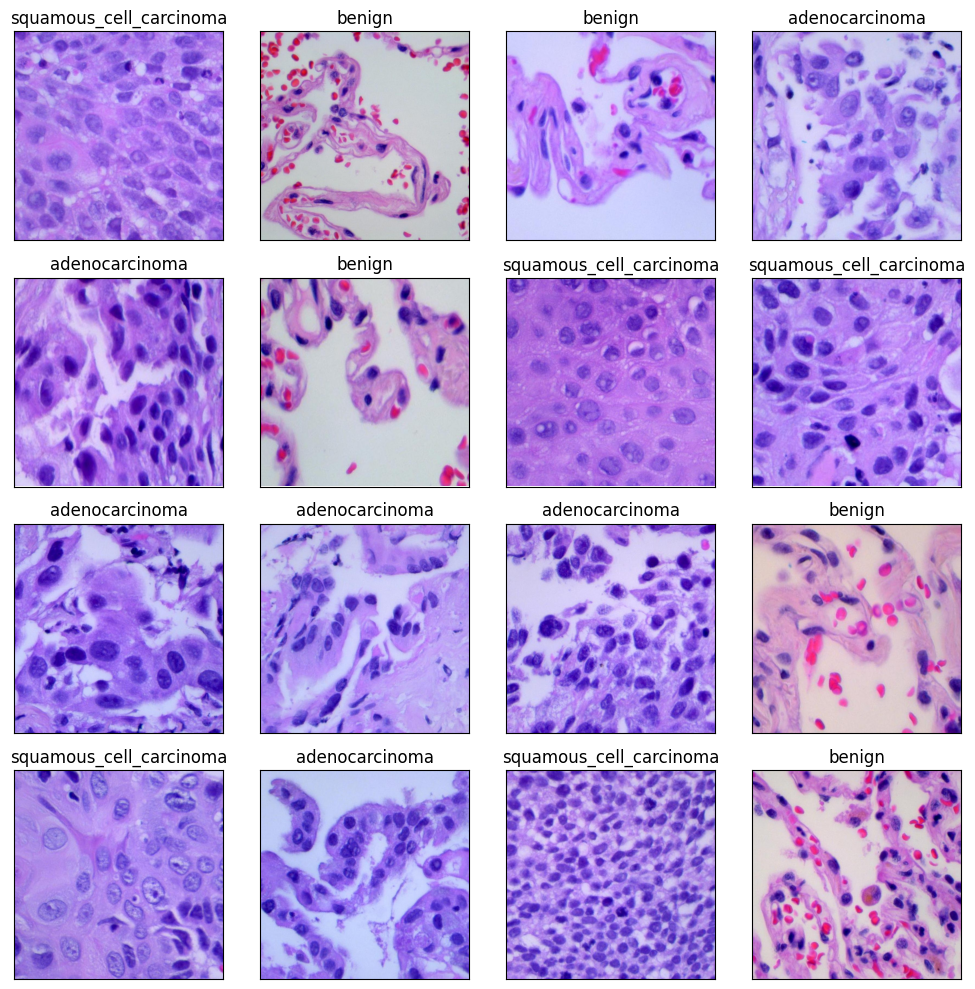

In [6]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df.shape

(12000, 2)

In [8]:
test_df.shape


(3000, 2)

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# Define the same rescaling for all sets (no augmentation)
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Still split into training and validation
)

## Training Set: 64%
train_images = data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

## Validation Set: 16%
val_images = data_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

## Test Set: 20%
test_images = data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 9600 validated image filenames belonging to 3 classes.
Found 2400 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [10]:
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetV2B1

# Load the EfficientNetB4 base model
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,  # Exclude the top classification layer
    weights='imagenet'  # Use pre-trained weights
)

# Freeze the base model to prevent training its weights
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Use GAP instead of Flatten for better generalization
    layers.Dense(512, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(3, activation='softmax')  # Output layer (3 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=3,         # Number of epochs with no improvement before stopping
    restore_best_weights=True # Restore model weights from the epoch with the best value
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitor validation loss
    factor=0.5,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement before reducing
    min_lr=1e-6           # Minimum learning rate
)

history = model.fit(
    train_images,
    epochs=15,  # Increase epochs as needed
    validation_data=val_images,
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 199s 608ms/step - accuracy: 0.3867 - loss: 1.1874 - val_accuracy: 0.4863 - val_loss: 1.0161
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 180s 590ms/step - accuracy: 0.4652 - loss: 1.0245 - val_accuracy: 0.5271 - val_loss: 0.9723
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 199s 579ms/step - accuracy: 0.5087 - loss: 0.9871 - val_accuracy: 0.5462 - val_loss: 0.9456
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 179s 589ms/step - accuracy: 0.5397 - loss: 0.9466 - val_accuracy: 0.5546 - val_loss: 0.8869
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 201s 584ms/step - accuracy: 0.5587 - loss: 0.9122 - val_accuracy: 0.6196 - val_loss: 0.8356
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 203s 589ms/step - accuracy: 0.5841 - loss: 0.8778 - val_accuracy: 0.6125 - val_loss: 0.8024
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 204s 596ms/step - accuracy: 0.6104 - loss: 0.8271 - val_accuracy: 0.6654 - val_loss: 0.7619
Epoch 8/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 177s 581ms/step - accuracy: 0.6144 - loss: 0.81

In [12]:
loss, accuracy = model.evaluate(val_images)
print(f"Validation Accuracy:{accuracy * 100:.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 467ms/step - accuracy: 0.7335 - loss: 0.6527
Validation Accuracy:75.21%


In [13]:
#Training set Accuracy
train_loss, train_acc = model.evaluate(train_images)
print(f"Training accuracy:{train_acc * 100:.2f}%")

300/300 ━━━━━━━━━━━━━━━━━━━━ 143s 477ms/step - accuracy: 0.7540 - loss: 0.6478
Training accuracy:76.22%


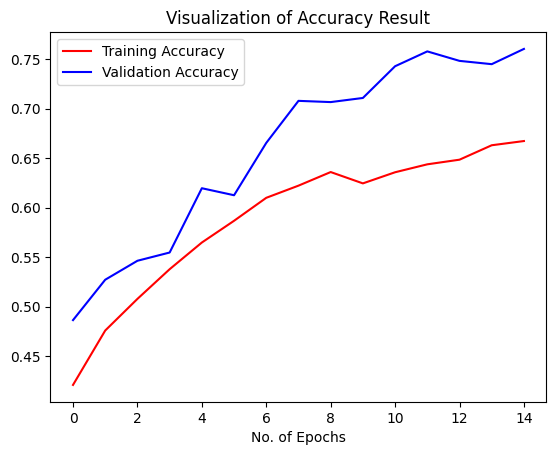

In [14]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy,color='red', label='Training Accuracy')
plt.plot(epochs, val_accuracy,color='blue', label='Validation Accuracy')
plt.title('Visualization of Accuracy Result')
plt.xlabel('No. of Epochs')
plt.legend();
plt.show()



In [15]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step


In [16]:
# Display the result
print(f'The first 10 predictions: {pred[:10]}')

The first 10 predictions: ['adenocarcinoma', 'adenocarcinoma', 'squamous_cell_carcinoma', 'benign', 'squamous_cell_carcinoma', 'adenocarcinoma', 'benign', 'benign', 'benign', 'benign']


In [17]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
print(df)

                         precision    recall  f1-score      support
adenocarcinoma            0.608169  0.828866  0.701571   970.000000
benign                    0.890323  0.931533  0.910462  1037.000000
squamous_cell_carcinoma   0.912310  0.544814  0.682219   993.000000
accuracy                  0.770333  0.770333  0.770333     0.770333
macro avg                 0.803601  0.768404  0.764751  3000.000000
weighted avg              0.806371  0.770333  0.767372  3000.000000


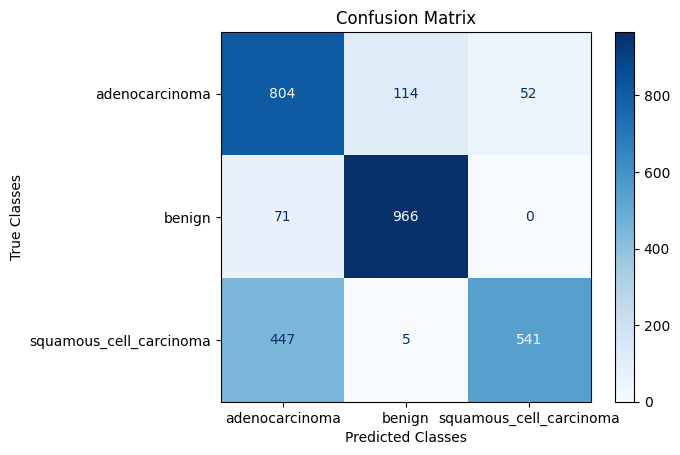

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and pred are defined
cm = confusion_matrix(y_test, pred)

# Define your class names
class_names = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']  # Replace with your actual class names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Change the color to blue
disp.plot(cmap='Blues')

plt.xlabel('Predicted Classes')  # Optional: add x-axis label
plt.ylabel('True Classes')        # Optional: add y-axis label
plt.title('Confusion Matrix')     # Optional: add title

plt.show()